In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import pickle
import matplotlib.pyplot as plt
plt.style.use("bmh")
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

---

### **Import the data**

These are the two relevant stations:

In [2]:
stations = {
    603: "Bonn",
    1303: "Essen"
}

Load .csv files from `cdc_download/data` folder into DataFrames.  
`prd.csv` contains information about the different tables: each table has a `Produkt_Code` .  
Each `Produkt_Code` has a `Produkt_Titel`.  

`sdo` data seems not to be useful.

In [3]:
def format_timestamp(ts):
    '''
    Turn integer like 201901010000 into datetime object. 
    '''
    ts = str(ts)
    year, month, day = int(ts[:4]), int(ts[4:6]), int(ts[6:8])
    hour, minute = int(ts[8:10]), int(ts[10:12])
    return datetime(year, month, day, hour, minute)

In [4]:
data = dict()
path = "data/cdc_download/data"
# prd.csv contains names of different "products" (tables)
prd = pd.read_csv(f"{path}/prd.csv")
# Drop Beschreibung_DWD and Beschreibung_Inspire from prd
prd = prd.drop(["Beschreibung_DWD", "Beschreibung_Inspire"], axis = 1)
# Load each of the downloaded weather table into its own dataframe:
for filename in os.listdir(path):
    if "data" in filename:
        # Add DataFrame to data dictionary
        code = filename.replace("data_", "").replace(".csv", "") # Produkt_Code
        data[code] = pd.read_csv(f"{path}/{filename}")
        
for i, code in enumerate(data.keys()):
    # Rename columns:
    data[code] = data[code].rename(columns={
        "Wert": prd[prd["Produkt_Code"] == code]["Produkt_Titel"].iloc[0],
        "SDO_ID": "station",
        "Zeitstempel": "timestamp"
    })
    # Replace SDO_ID (station ID) by station name:
    data[code]["station"] = data[code]["station"].apply(lambda x: stations[x])
    # Replace timestamp by formatted timestamp:
    data[code]["timestamp"] = data[code]["timestamp"].apply(format_timestamp)
    # Drop Produkt_Code (we don't need a column for this?)
    # Drop Qualitaet_Niveau, Qualitaet_Byte (Do we need them??)
    data[code] = data[code].drop(
        ["Produkt_Code", "Qualitaet_Niveau", "Qualitaet_Byte"], axis=1)
    # Reset the index
    data[code] = data[code].reset_index()
    data[code] = data[code].drop("index", axis=1)

In [5]:
# Which tables are there?
for i in range(prd.shape[0]):
    print(prd["Produkt_Titel"].iloc[i])

Hourly station observations of air temperature at 2 m above ground in °C
Hourly station observations of dew point temperature 2 m above ground in °C
Hourly station observations of relative humidity in %
Hourly station observations of precipitation amount in mm
Hourly station observations of form of precipitation (WR code)
Hourly station observations of index whether precipitation has fallen
Hourly station observations of wind velocity 10 m above ground in m/s
Hourly station observations of wind direction 10 m above ground in degree
Hourly mean of station observations of wind speed ca. 10 m above ground in m/s
Hourly mean of station observations of wind direction at ca. 10 m above ground in degree
Hourly station observations of air pressure at station level in hpa
Hourly station observations of air pressure at mean sea level in hpa
Hourly station observations of cloud coverage in eighths
Hourly station observations of soil temperature at the depth of 5 cm in °C
Hourly station observatio

In [6]:
# Order data like in prd
key_order = key_order=["TT_TU_MN009", "TD_MN008", "RF_TU_MN009", "R1_MN008", "WRTR_MN008", "RS_IND_MN008", 
                       "FF_MN008", "DD_MN008", "F_MN003", "D_MN003", "P0_MN008", "P_MN008", "N_MN008", 
                       "TE05_MN002", "TE10_MN002", "TE20_MN002", "TE50_MN002", "TE100_MN002"]
data = {k : data[k] for k in key_order}

---

### **Missing datapoints**

Not all features have data for all timestamps (especially for Bonn).  
Let's look a bit more closely at this: 

In [7]:
print("Essen")
for product_code, table in data.items():
    series = table[table["station"] == "Essen"]["timestamp"]
    annotation = "!!!" if series.count() < 3600 else ""
    # !!! means for this feature (in this city), there are datapoints missing!
    print(product_code, "\t", series.count(),"/ 3600", annotation)

Essen
TT_TU_MN009 	 3600 / 3600 
TD_MN008 	 3557 / 3600 !!!
RF_TU_MN009 	 3557 / 3600 !!!
R1_MN008 	 3600 / 3600 
WRTR_MN008 	 2398 / 3600 !!!
RS_IND_MN008 	 3600 / 3600 
FF_MN008 	 3600 / 3600 
DD_MN008 	 3600 / 3600 
F_MN003 	 3600 / 3600 
D_MN003 	 3600 / 3600 
P0_MN008 	 3600 / 3600 
P_MN008 	 3600 / 3600 
N_MN008 	 3594 / 3600 !!!
TE05_MN002 	 3600 / 3600 
TE10_MN002 	 3600 / 3600 
TE20_MN002 	 3600 / 3600 
TE50_MN002 	 3600 / 3600 
TE100_MN002 	 3600 / 3600 


In [8]:
print("Bonn")
for product_code, table in data.items():
    series = table[table["station"] == "Bonn"]["timestamp"]
    annotation = "!!!" if series.count() < 3600 else ""
    # !!! means for this feature (in this city), there are datapoints missing!
    print(product_code, "\t", series.count(),"/ 3600", annotation)

Bonn
TT_TU_MN009 	 3586 / 3600 !!!
TD_MN008 	 3586 / 3600 !!!
RF_TU_MN009 	 3586 / 3600 !!!
R1_MN008 	 3585 / 3600 !!!
WRTR_MN008 	 2390 / 3600 !!!
RS_IND_MN008 	 3585 / 3600 !!!
FF_MN008 	 3586 / 3600 !!!
DD_MN008 	 3586 / 3600 !!!
F_MN003 	 3586 / 3600 !!!
D_MN003 	 3587 / 3600 !!!
P0_MN008 	 3586 / 3600 !!!
P_MN008 	 3586 / 3600 !!!
N_MN008 	 3573 / 3600 !!!
TE05_MN002 	 3586 / 3600 !!!
TE10_MN002 	 3586 / 3600 !!!
TE20_MN002 	 3586 / 3600 !!!
TE50_MN002 	 3586 / 3600 !!!
TE100_MN002 	 3586 / 3600 !!!


#### **Split data and join all tables**

In [9]:
dti = pd.date_range('2019-02-01', periods=3600, freq='H')
ts = pd.DataFrame({ 'timestamp': dti }) 
ts

,timestamp
0,2019-02-01 00:00:00
1,2019-02-01 01:00:00
2,2019-02-01 02:00:00
3,2019-02-01 03:00:00
4,2019-02-01 04:00:00
...,...
3595,2019-06-30 19:00:00
3596,2019-06-30 20:00:00
3597,2019-06-30 21:00:00
3598,2019-06-30 22:00:00


In [10]:
data_bonn = dict()
data_essen = dict()
for product_code, table in data.items():
    # Spliting data based on their station
    data_bonn[product_code] = table[table["station"] == "Bonn"].reset_index(drop = True)
    data_essen[product_code] = table[table["station"] == "Essen"]
    
    # Left join on timestamp with the ts dataframe
    data_bonn[product_code] = pd.merge(ts, data_bonn[product_code], how='left', on="timestamp")
    data_essen[product_code] = pd.merge(ts, data_essen[product_code], how='left', on="timestamp")

In [11]:
# Bonn
df_bonn = pd.concat(list(data_bonn.values()), axis=1, join="outer")
# Outer join! No information is lost => many null entries
df_bonn = df_bonn.loc[:, ~df_bonn.columns.duplicated()] # remove duplicate columns
df_bonn = df_bonn.rename(columns={
    "Hourly station observations of air temperature at 2 m above ground in °C": "temperature_2m",
    "Hourly station observations of dew point temperature 2 m above ground in °C": "dew_point_temperature_2m",
    "Hourly station observations of relative humidity in %": "relative_humidity",
    "Hourly station observations of precipitation amount in mm": "precipitation",
    "Hourly station observations of form of precipitation (WR code)": "precipitation_form",
    "Hourly station observations of index whether precipitation has fallen": "has_precipitated",
    "Hourly station observations of wind velocity 10 m above ground in m/s": "wind_velocity_10m",
    "Hourly station observations of wind direction 10 m above ground in degree": "wind_direction_10m",
    "Hourly mean of station observations of wind speed ca. 10 m above ground in m/s": "mean_wind_speed_10m",
    "Hourly mean of station observations of wind direction at ca. 10 m above ground in degree": "mean_wind_direction_10m",
    "Hourly station observations of air pressure at station level in hpa": "air_pressure_station_level",
    "Hourly station observations of air pressure at mean sea level in hpa": "air_pressure_sea_level",
    "Hourly station observations of cloud coverage in eighths": "cloud_coverage",   
    "Hourly station observations of soil temperature at the depth of 5 cm in °C": "soil_temperature_5cm",
    "Hourly station observations of soil temperature at the depth of 10 cm in °C": "soil_temperature_10cm",
    "Hourly station observations of soil temperature at the depth of 20 cm in °C": "soil_temperature_20cm",
    "Hourly station observations of soil temperature at the depth of 50 cm in °C": "soil_temperature_50cm",
    "Hourly station observations of soil temperature at the depth of 100 cm in °C": "soil_temperature_100cm",
})
df_bonn = df_bonn.drop(["station"], axis=1)

# Essen
df_essen = pd.concat(list(data_essen.values()), axis=1, join="outer")
# Outer join! No information is lost => many null entries
df_essen = df_essen.loc[:, ~df_essen.columns.duplicated()] # remove duplicate columns
df_essen = df_essen.rename(columns={
    "Hourly station observations of air temperature at 2 m above ground in °C": "temperature_2m",
    "Hourly station observations of dew point temperature 2 m above ground in °C": "dew_point_temperature_2m",
    "Hourly station observations of relative humidity in %": "relative_humidity",
    "Hourly station observations of precipitation amount in mm": "precipitation",
    "Hourly station observations of form of precipitation (WR code)": "precipitation_form",
    "Hourly station observations of index whether precipitation has fallen": "has_precipitated",
    "Hourly station observations of wind velocity 10 m above ground in m/s": "wind_velocity_10m",
    "Hourly station observations of wind direction 10 m above ground in degree": "wind_direction_10m",
    "Hourly mean of station observations of wind speed ca. 10 m above ground in m/s": "mean_wind_speed_10m",
    "Hourly mean of station observations of wind direction at ca. 10 m above ground in degree": "mean_wind_direction_10m",
    "Hourly station observations of air pressure at station level in hpa": "air_pressure_station_level",
    "Hourly station observations of air pressure at mean sea level in hpa": "air_pressure_sea_level",
    "Hourly station observations of cloud coverage in eighths": "cloud_coverage",   
    "Hourly station observations of soil temperature at the depth of 5 cm in °C": "soil_temperature_5cm",
    "Hourly station observations of soil temperature at the depth of 10 cm in °C": "soil_temperature_10cm",
    "Hourly station observations of soil temperature at the depth of 20 cm in °C": "soil_temperature_20cm",
    "Hourly station observations of soil temperature at the depth of 50 cm in °C": "soil_temperature_50cm",
    "Hourly station observations of soil temperature at the depth of 100 cm in °C": "soil_temperature_100cm",
})
df_essen = df_essen.drop(["station"], axis=1)

#### **Fill missing data**

In [12]:
# Drop precipitation_form as about 1/3 of the data is missing and the feature seems not to be useful for prediction
df_bonn = df_bonn.drop(["precipitation_form"], axis=1)
df_essen = df_essen.drop(["precipitation_form"], axis=1)
prd = prd.drop(index=4).reset_index(drop = True)

In [13]:
df_bonn[df_bonn.isnull().any(axis=1)].count()

timestamp                     27
temperature_2m                13
dew_point_temperature_2m      13
relative_humidity             13
precipitation                 12
has_precipitated              12
wind_velocity_10m             13
wind_direction_10m            13
mean_wind_speed_10m           13
mean_wind_direction_10m       14
air_pressure_station_level    13
air_pressure_sea_level        13
cloud_coverage                 0
soil_temperature_5cm          13
soil_temperature_10cm         13
soil_temperature_20cm         13
soil_temperature_50cm         13
soil_temperature_100cm        13
dtype: int64

In [14]:
df_essen[df_essen.isnull().any(axis=1)].count()

timestamp                     49
temperature_2m                49
dew_point_temperature_2m       6
relative_humidity              6
precipitation                 49
has_precipitated              49
wind_velocity_10m             49
wind_direction_10m            49
mean_wind_speed_10m           49
mean_wind_direction_10m       49
air_pressure_station_level    49
air_pressure_sea_level        49
cloud_coverage                43
soil_temperature_5cm          49
soil_temperature_10cm         49
soil_temperature_20cm         49
soil_temperature_50cm         49
soil_temperature_100cm        49
dtype: int64

In [15]:
# Fill missing values via forward-fill
df_bonn = df_bonn.fillna(method='ffill')
df_essen = df_essen.fillna(method='ffill')

In [16]:
df_bonn[df_bonn.isnull().any(axis=1)].count()

timestamp                     0
temperature_2m                0
dew_point_temperature_2m      0
relative_humidity             0
precipitation                 0
has_precipitated              0
wind_velocity_10m             0
wind_direction_10m            0
mean_wind_speed_10m           0
mean_wind_direction_10m       0
air_pressure_station_level    0
air_pressure_sea_level        0
cloud_coverage                0
soil_temperature_5cm          0
soil_temperature_10cm         0
soil_temperature_20cm         0
soil_temperature_50cm         0
soil_temperature_100cm        0
dtype: int64

In [17]:
df_essen[df_essen.isnull().any(axis=1)].count()

timestamp                     0
temperature_2m                0
dew_point_temperature_2m      0
relative_humidity             0
precipitation                 0
has_precipitated              0
wind_velocity_10m             0
wind_direction_10m            0
mean_wind_speed_10m           0
mean_wind_direction_10m       0
air_pressure_station_level    0
air_pressure_sea_level        0
cloud_coverage                0
soil_temperature_5cm          0
soil_temperature_10cm         0
soil_temperature_20cm         0
soil_temperature_50cm         0
soil_temperature_100cm        0
dtype: int64

---

### **Plot the features**

In [18]:
def plot_feature(i):
    # i: feature number (0, ..., 16)
    plt.style.use("bmh")
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title(prd["Produkt_Titel"].iloc[i], fontsize=12, fontweight="bold", pad=10) 
    ax.yaxis.tick_right()
    ax.plot(df_essen["timestamp"], df_essen.iloc[:,i+1], alpha=0.7, label="Essen")
    ax.plot(df_bonn["timestamp"], df_bonn.iloc[:,i+1], alpha=0.7, label="Bonn")
    ax.legend()
    fig.tight_layout()

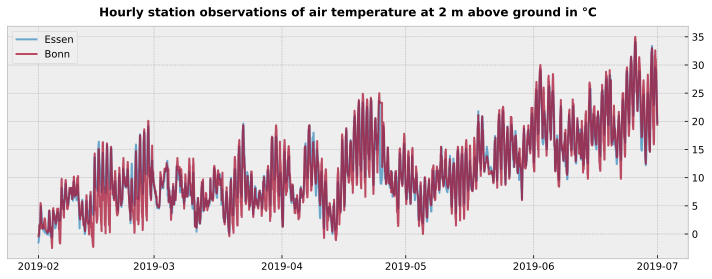

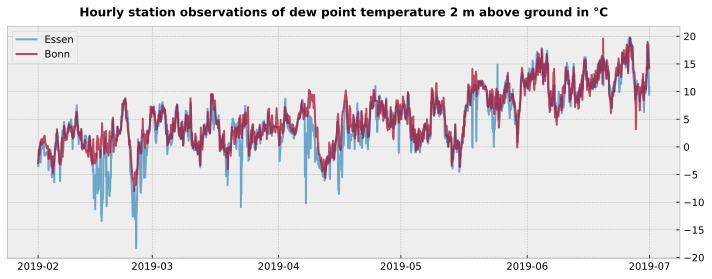

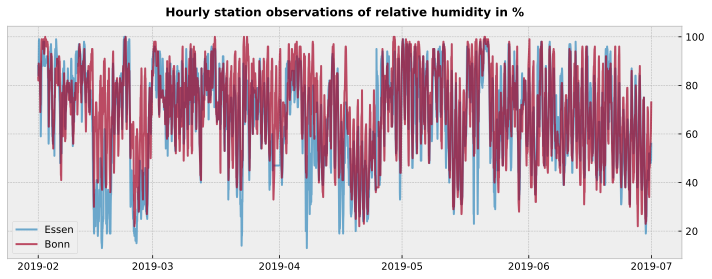

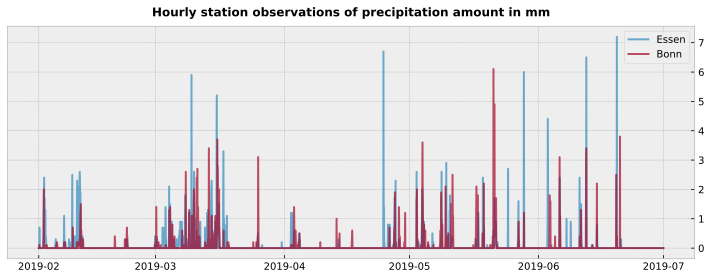

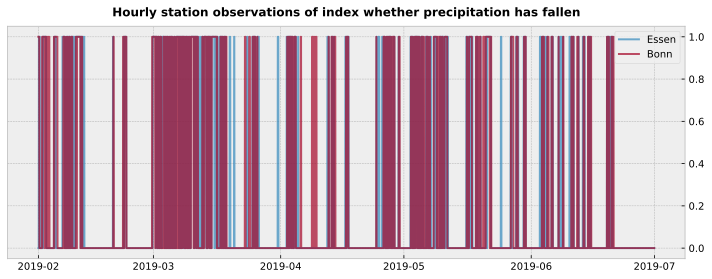

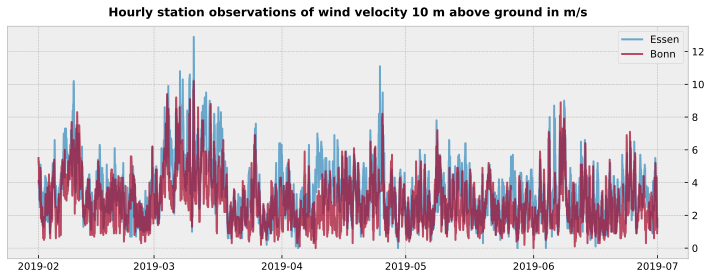

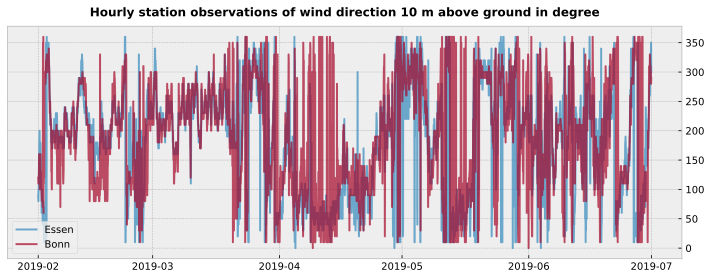

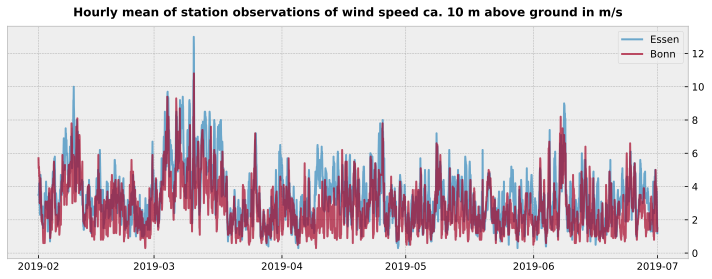

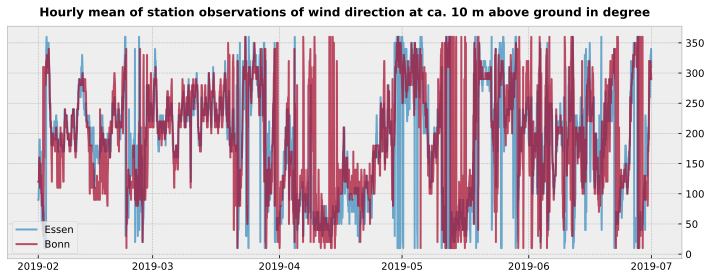

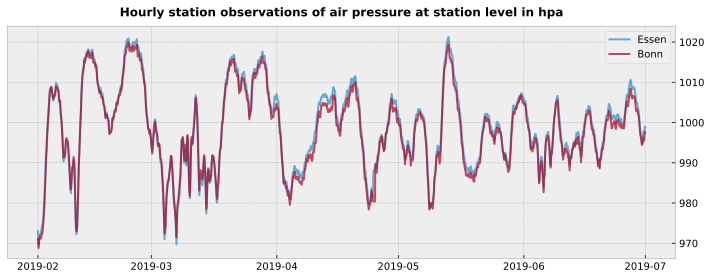

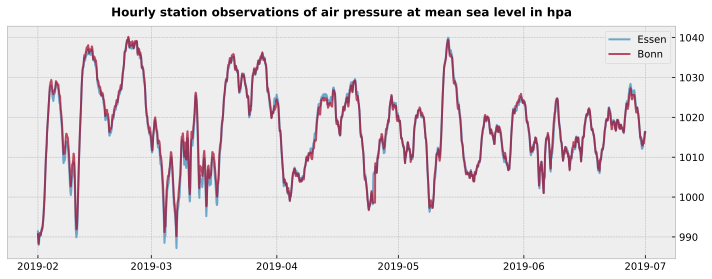

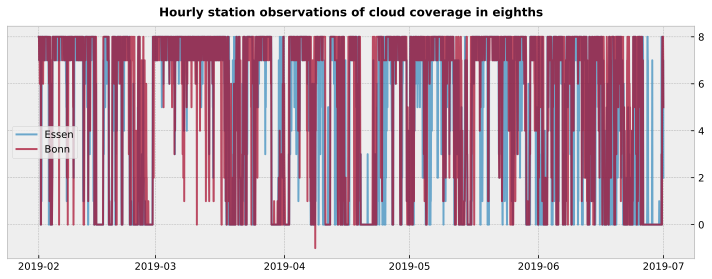

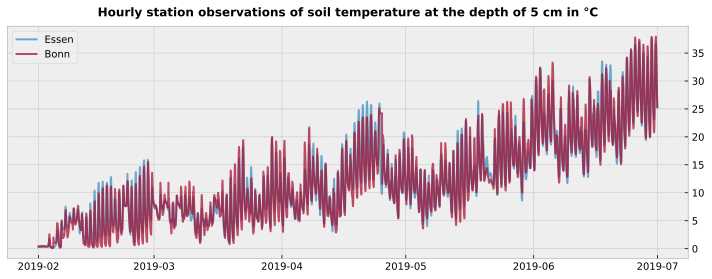

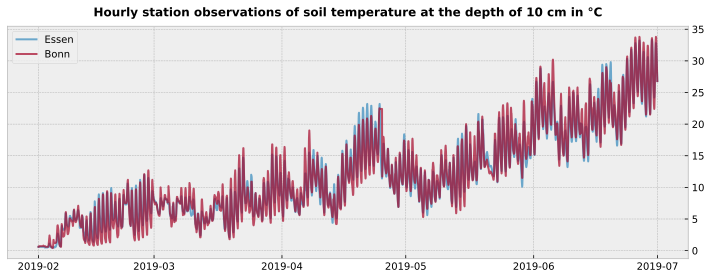

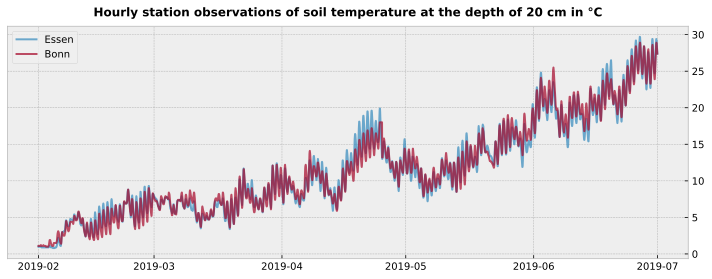

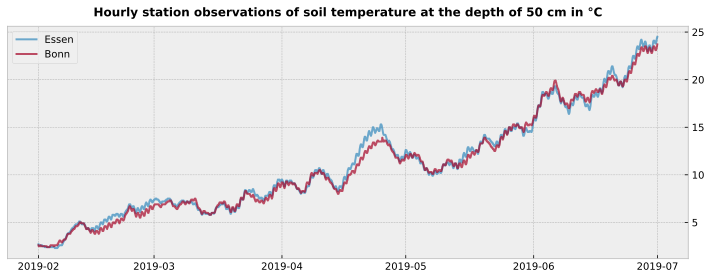

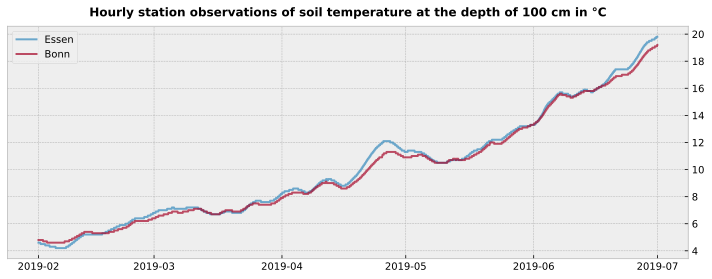

In [19]:
for feature_number in range(0, 17):
    plot_feature(feature_number)

#### Correlation between features

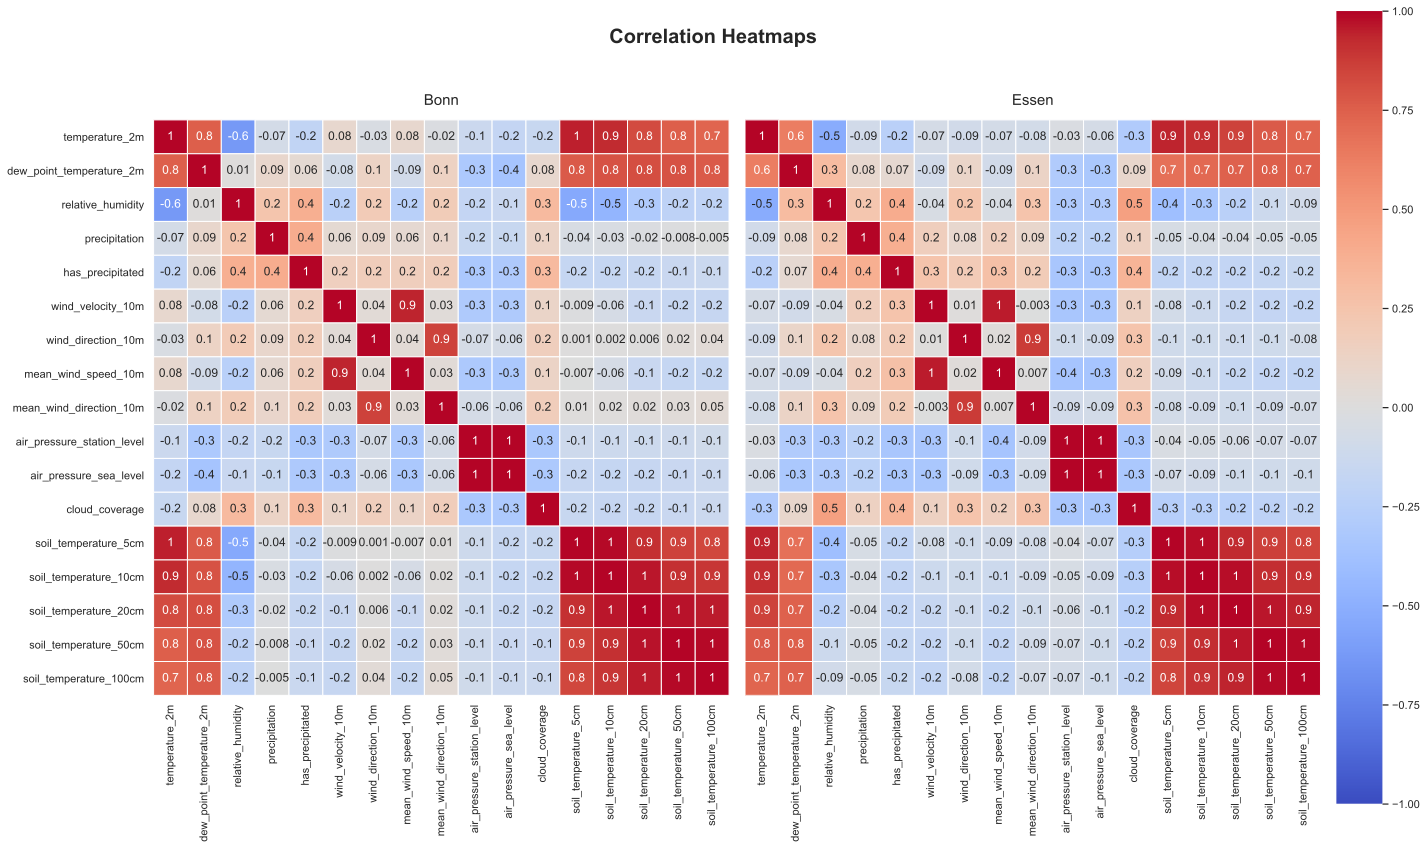

In [20]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(20,12))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=1.0)

#plt.savefig('heatmaps.png', bbox_inches='tight')
plt.show()

We see that some of the features highly correlate with others.    
This might be interesting in combination with a feature selection for our machine learning analysis. 

---

### **Save to files**

In [21]:
# Export Data to Pickle File
df_bonn.to_pickle("data/df_weather_bonn.pickle")
df_essen.to_pickle("data/df_weather_essen.pickle")